In [2]:
!pip install yfinance pandas pyyaml nsepy yahoofinancials matplotlib seaborn scipy sqlalchemy mysql-connector-python plotly

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import os

# ------------------------------------
# Database connection details
# ------------------------------------
db_config = {
    "host": "gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
    "port": 4000,
    "user": "2JRRhPHCS6mRsGW.root",
    "password": "48euDwRpY6OmYT5A",
    "database": "nifty50_project",
    "ssl_ca": r"D:\path\to\ca.pem"
}

# --- Build connection string for SQLAlchemy ---
conn_str = (
    f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['database']}"
    f"?ssl_ca={db_config['ssl_ca']}"
)

# ------------------------------------
# Create the database engine
# ------------------------------------
try:
    engine = create_engine(conn_str)
    print("✅ Database engine created successfully.")
except Exception as e:
    print(f"❌ Error creating database engine: {e}")
    exit()

# ------------------------------------
# Read data from SQL into DataFrame
# ------------------------------------
try:
    df_clean = pd.read_sql("SELECT * FROM nifty50_data", con=engine)
    print("✅ Data loaded successfully.")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit()

# ------------------------------------
# Save the DataFrame to the SQL database
# ------------------------------------
try:
    df_clean.to_sql(
        name="nifty50_cleaned",  # The name of the table to save to
        con=engine,
        if_exists="replace",
        index=False
    )
    print("✅ DataFrame successfully saved to the 'nifty50_cleaned' table.")
except Exception as e:
    print(f"❌ Error saving DataFrame: {e}")
finally:
    if 'engine' in locals():
        engine.dispose()

✅ Database engine created successfully.
✅ Data loaded successfully.
✅ DataFrame successfully saved to the 'nifty50_cleaned' table.


In [4]:
# SQL query to fetch your Nifty 50 data
query = "SELECT * FROM nifty50_data"  # replace with your actual table name

# Load into DataFrame
df_clean = pd.read_sql(query, engine)

# Preview first 5 rows
print(df_clean.head())


         Stock       Date     Open     High      Low    Close    Volume  \
0  ADANIENT.NS 2024-01-01  2849.69  2944.31  2839.45  2914.53   2898619   
1  ADANIENT.NS 2024-01-02  2919.33  2945.51  2838.40  2929.72   2671368   
2  ADANIENT.NS 2024-01-03  3044.22  3196.08  2952.90  3000.26  19725411   
3  ADANIENT.NS 2024-01-04  3036.62  3041.67  2987.27  2995.56   2975620   
4  ADANIENT.NS 2024-01-05  3007.20  3064.10  2978.38  3003.85   3219949   

   Sector  
0  Energy  
1  Energy  
2  Energy  
3  Energy  
4  Energy  


In [5]:
df_clean['Date'] = pd.to_datetime(df_clean['Date'])


In [7]:
# ------------------------------------
# 1. Daily Return = (Close - Prev_Close) / Prev_Close * 100
# ------------------------------------
df_clean["Prev_Close"] = df_clean.groupby("Stock")["Close"].shift(1)
df_clean["Daily_Return"] = (
    (df_clean["Close"] - df_clean["Prev_Close"]) / df_clean["Prev_Close"]
) * 100

# ------------------------------------
# 2. Yearly Return per Stock
#    (Last_Close - First_Close) / First_Close * 100
# ------------------------------------
yearly = (
    df_clean.groupby("Stock")
    .agg(
        First_Close=("Close", "first"),
        Last_Close=("Close", "last"),
        Avg_Price=("Close", "mean"),
        Avg_Volume=("Volume", "mean")   # ✅ added average volume
    )
    .reset_index()
)

yearly["Yearly_Return"] = (
    (yearly["Last_Close"] - yearly["First_Close"]) /
    yearly["First_Close"]
) * 100

# ------------------------------------
# 3. Market Summary
# ------------------------------------
top_10_green = yearly.sort_values(by="Yearly_Return", ascending=False).head(10)
top_10_loss = yearly.sort_values(by="Yearly_Return", ascending=True).head(10)

green_count = (yearly["Yearly_Return"] > 0).sum()
red_count = (yearly["Yearly_Return"] <= 0).sum()
avg_price = yearly["Avg_Price"].mean()
avg_volume = yearly["Avg_Volume"].mean()   # ✅ overall average volume

# ------------------------------------
# 4. Results
# ------------------------------------
print("\n✅ Daily Returns:\n", df_clean[["Date", "Stock", "Close", "Prev_Close", "Daily_Return"]])
print("\n✅ Top 10 Green Stocks:\n", top_10_green[["Stock", "Yearly_Return"]])
print("\n✅ Top 10 Loss Stocks:\n", top_10_loss[["Stock", "Yearly_Return"]])
print("\n📊 Market Summary:")
print(f"Green Stocks: {green_count}")
print(f"Red Stocks: {red_count}")
print(f"Average Price: {avg_price:.2f}")
print(f"Average Volume: {avg_volume:.2f}")
df_clean.to_csv("nifty50_cleaned.csv", index=False)
print("✅ File saved successfully to 'nifty50_cleaned.csv'")


✅ Daily Returns:
             Date        Stock    Close  Prev_Close  Daily_Return
0     2024-01-01  ADANIENT.NS  2914.53         NaN           NaN
1     2024-01-02  ADANIENT.NS  2929.72     2914.53      0.521182
2     2024-01-03  ADANIENT.NS  3000.26     2929.72      2.407739
3     2024-01-04  ADANIENT.NS  2995.56     3000.26     -0.156653
4     2024-01-05  ADANIENT.NS  3003.85     2995.56      0.276743
...          ...          ...      ...         ...           ...
12295 2024-12-24      ZEEL.NS   123.55      123.04      0.414499
12296 2024-12-26      ZEEL.NS   122.28      123.55     -1.027924
12297 2024-12-27      ZEEL.NS   122.15      122.28     -0.106313
12298 2024-12-30      ZEEL.NS   119.59      122.15     -2.095784
12299 2024-12-31      ZEEL.NS   118.80      119.59     -0.660590

[12300 rows x 5 columns]

✅ Top 10 Green Stocks:
             Stock  Yearly_Return
30         M&M.NS      77.838254
8          BEL.NS      60.103484
9   BHARTIARTL.NS      57.603996
13    DIVISLAB.NS 

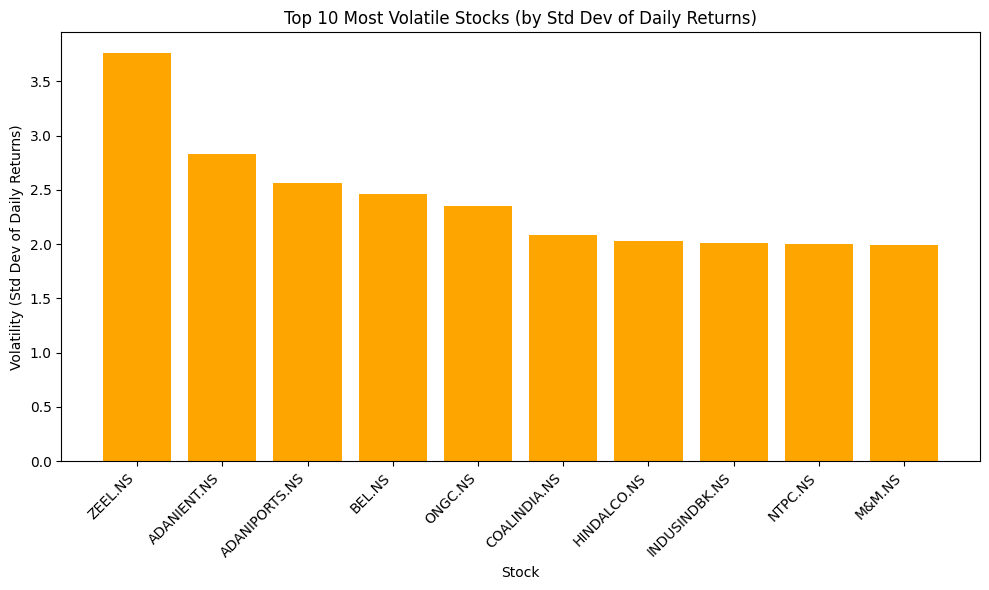


📊 Top 10 Most Volatile Stocks:
             Stock  Volatility
49        ZEEL.NS    3.763416
0     ADANIENT.NS    2.835097
1   ADANIPORTS.NS    2.566483
8          BEL.NS    2.464084
34        ONGC.NS    2.352641
12   COALINDIA.NS    2.085300
21    HINDALCO.NS    2.027983
23  INDUSINDBK.NS    2.006366
33        NTPC.NS    1.997444
30         M&M.NS    1.993704
✅ File saved successfully: 'nifty50_cleaned_with_volatility.csv'


In [11]:
# ------------------------------------
# 2. Compute Volatility (Std Dev of Daily Returns)
# ------------------------------------
import matplotlib.pyplot as plt

# Step 1: Compute volatility per stock -> DataFrame
volatility_df = df_clean.groupby("Stock")["Daily_Return"].std().reset_index()
volatility_df.columns = ["Stock", "Volatility"]

# Step 2: Merge back into df_clean
df_clean = df_clean.merge(volatility_df, on="Stock", how="left")

# Step 3: Get Top 10 most volatile
top_10_vol = volatility_df.sort_values("Volatility", ascending=False).head(10)

# ------------------------------------
# 3. Plot Bar Chart
# ------------------------------------
plt.figure(figsize=(10,6))
plt.bar(top_10_vol["Stock"], top_10_vol["Volatility"], color="orange")
plt.title("Top 10 Most Volatile Stocks (by Std Dev of Daily Returns)")
plt.xlabel("Stock")
plt.ylabel("Volatility (Std Dev of Daily Returns)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ------------------------------------
# 4. Save Final Dataset
# ------------------------------------
df_clean.to_csv("nifty50_cleaned_with_volatility.csv", index=False)

print("\n📊 Top 10 Most Volatile Stocks:\n", top_10_vol)
print("✅ File saved successfully: 'nifty50_cleaned_with_volatility.csv'")


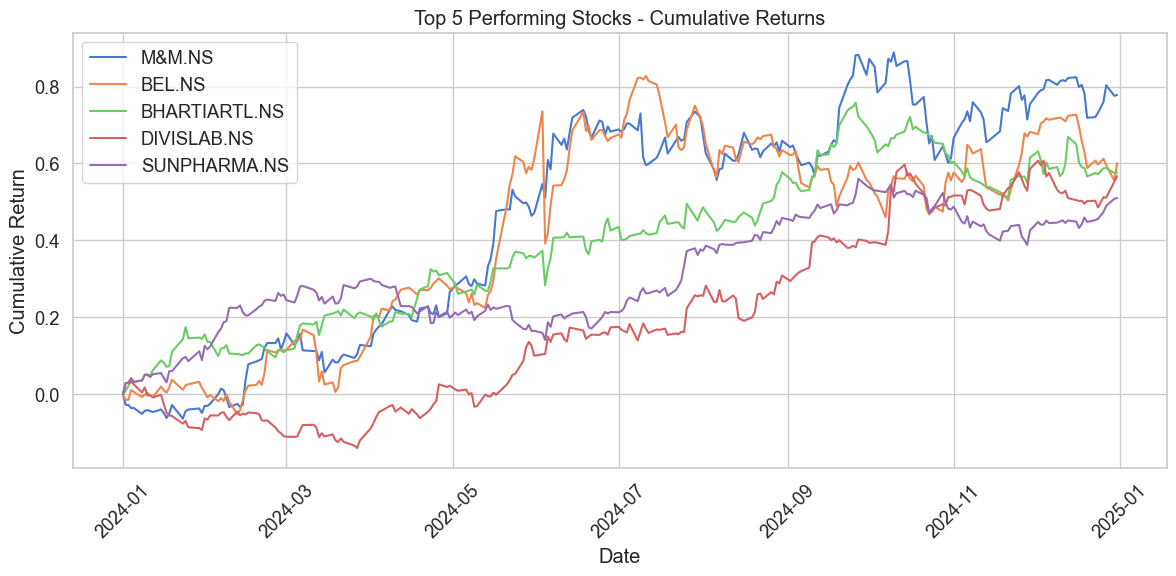


📊 Top 5 Performing Stocks (Final Cumulative Returns):
            Stock  Cumulative_Return
0         M&M.NS           0.778383
1         BEL.NS           0.601035
2  BHARTIARTL.NS           0.576040
3    DIVISLAB.NS           0.567006
4   SUNPHARMA.NS           0.510112
✅ File saved successfully to 'nifty50_cleaned.csv'


In [27]:
# Cumulative Return Over Time:
import matplotlib.pyplot as plt

df_clean["Cumulative_Return"] = df_clean.groupby("Stock")["Daily_Return"].transform(
    lambda x: (1 + x).cumprod() - 1
)

# ------------------------------------
#  Final Cumulative Return per Stock
# ------------------------------------
# Sort by Stock and Date
df_clean = df_clean.sort_values(by=["Stock", "Date"])

# Fill missing returns
df_clean["Daily_Return"] = df_clean["Daily_Return"].fillna(0)

# Calculate cumulative return
df_clean["Cumulative_Return"] = df_clean.groupby("Stock")["Daily_Return"].transform(
    lambda x: (1 + x / 100).cumprod() - 1
)

# Get final cumulative return per stock
final_returns = (
    df_clean.groupby("Stock").tail(1)[["Stock", "Cumulative_Return"]]
    .sort_values(by="Cumulative_Return", ascending=False)
    .reset_index(drop=True)
)

# Top 5 stocks
top_5_stocks = final_returns.head(5)["Stock"].tolist()


# ------------------------------------
# 4. Plot Line Chart
# ------------------------------------
plt.figure(figsize=(12, 6))

for stock in top_5_stocks:
    stock_data = df_clean[df_clean["Stock"] == stock]
    plt.plot(stock_data["Date"], stock_data["Cumulative_Return"], label=stock)

plt.title("Top 5 Performing Stocks - Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------
# 5. Results
# ------------------------------------
print("\n📊 Top 5 Performing Stocks (Final Cumulative Returns):\n", final_returns.head(5))
import os

# Create a safe output folder
os.makedirs("output", exist_ok=True)

# Save the file
df_clean.to_csv("nifty50_cleaned.csv", index=False)
print("✅ File saved successfully to 'nifty50_cleaned.csv'")




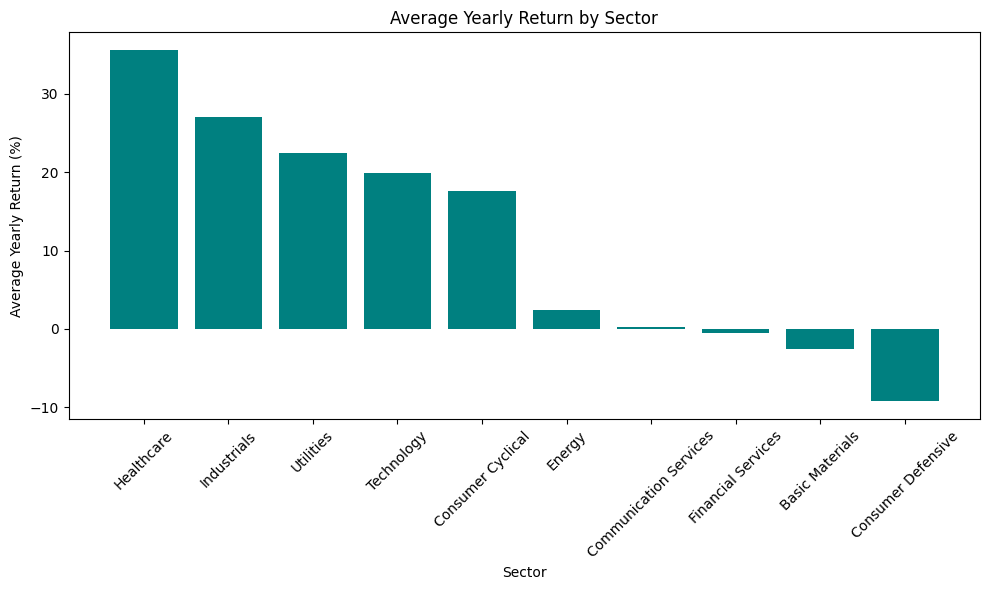


📊 Average Yearly Return by Sector:
                    Sector  Yearly_Return
6              Healthcare      35.626269
7             Industrials      27.077316
9               Utilities      22.469131
8              Technology      19.903548
2       Consumer Cyclical      17.659181
4                  Energy       2.378017
1  Communication Services       0.249138
5      Financial Services      -0.563845
0         Basic Materials      -2.617055
3      Consumer Defensive      -9.282424
✅ File saved successfully to 'nifty50_cleaned.csv'


In [15]:
import matplotlib.pyplot as plt

# ------------------------------------
# 1. Compute Yearly Return per Stock
# ------------------------------------
yearly = (
    df_clean.groupby(["Stock", "Sector"])  # ✅ keep Sector
    .agg(
        First_Close=("Close", "first"),
        Last_Close=("Close", "last")
    )
    .reset_index()
)

yearly["Yearly_Return"] = (
    (yearly["Last_Close"] - yearly["First_Close"]) /
    yearly["First_Close"]
) * 100

# ------------------------------------
# 2. Average Return by Sector
# ------------------------------------
sector_perf = (
    yearly.groupby("Sector")["Yearly_Return"]
    .mean()
    .reset_index()
    .sort_values(by="Yearly_Return", ascending=False)
)

# ------------------------------------
# 3. Plot Sector Performance
# ------------------------------------
plt.figure(figsize=(10, 6))
plt.bar(sector_perf["Sector"], sector_perf["Yearly_Return"], color="teal")
plt.title("Average Yearly Return by Sector")
plt.xlabel("Sector")
plt.ylabel("Average Yearly Return (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------
# 4. Print Results
# ------------------------------------
print("\n📊 Average Yearly Return by Sector:\n", sector_perf)
# Save the file
df_clean.to_csv("nifty50_cleaned.csv", index=False)
print("✅ File saved successfully to 'nifty50_cleaned.csv'")


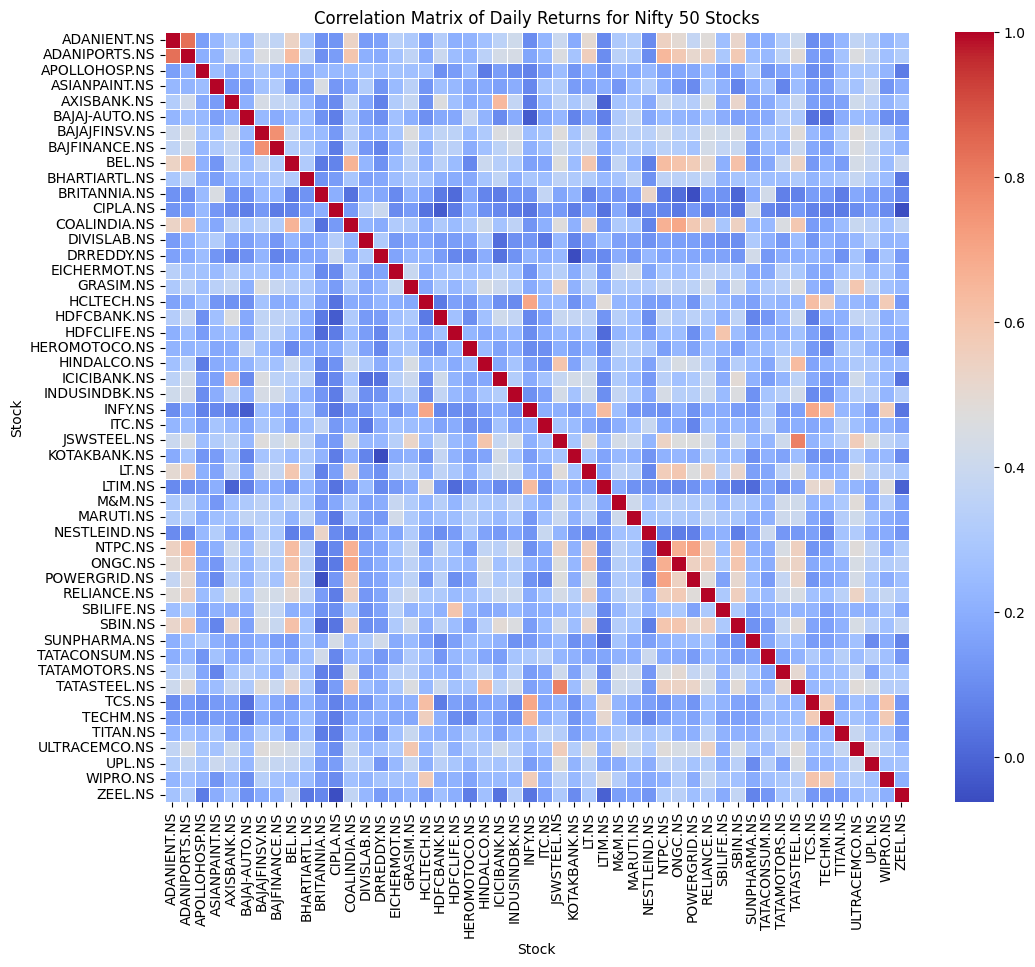


Top 10 Highly Correlated Stock Pairs:
 Stock          Stock        
ADANIENT.NS    ADANIPORTS.NS    0.833417
ADANIPORTS.NS  ADANIENT.NS      0.833417
JSWSTEEL.NS    TATASTEEL.NS     0.795714
TATASTEEL.NS   JSWSTEEL.NS      0.795714
BAJFINANCE.NS  BAJAJFINSV.NS    0.755616
BAJAJFINSV.NS  BAJFINANCE.NS    0.755616
POWERGRID.NS   NTPC.NS          0.706853
NTPC.NS        POWERGRID.NS     0.706853
HCLTECH.NS     INFY.NS          0.700931
INFY.NS        HCLTECH.NS       0.700931
dtype: float64
✅ Files saved successfully:
   - nifty50_cleaned.csv (price data)
   - nifty50_correlation_matrix.csv (correlation matrix)
   - nifty50_analysis.xlsx (both price data and correlation matrix)


In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------
# 1. Pivot df_clean to have dates as index and stocks as columns
# ------------------------------------
price_pivot = df_clean.pivot(index="Date", columns="Stock", values="Close")

# ------------------------------------
# 2. Compute correlation matrix
# ------------------------------------
corr_matrix = price_pivot.pct_change().corr()  # Use pct_change() for daily returns correlation

# ------------------------------------
# 3. Plot heatmap
# ------------------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns for Nifty 50 Stocks")
plt.show()

# ------------------------------------
# 4. Print top correlated pairs (optional)
# ------------------------------------
# Unstack, sort, remove self-correlations
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlation
print("\nTop 10 Highly Correlated Stock Pairs:\n", corr_pairs.head(10))

# ------------------------------------
# 5. Add correlation matrix to the dataframe and save
# ------------------------------------
# First, save the cleaned data
df_clean.to_csv("nifty50_cleaned.csv", index=False)

# Create a new DataFrame for the correlation matrix
corr_df = corr_matrix.reset_index()
corr_df.rename(columns={'index': 'Stock'}, inplace=True)

# Save correlation matrix to a separate CSV
corr_df.to_csv("nifty50_correlation_matrix.csv", index=False)


    
print("✅ Files saved successfully:")
print("   - nifty50_cleaned.csv (price data)")
print("   - nifty50_correlation_matrix.csv (correlation matrix)")
print("   - nifty50_analysis.xlsx (both price data and correlation matrix)")

In [ ]:
!pip install nbformat ipython kaleido --upgrade kaleido



C:\Users\Balamurugan\AppData\Local\Temp\ipykernel_26096\2607669871.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_gainers = monthly_return.groupby("Month").apply(lambda x: x.nlargest(5, "Monthly_Return")).reset_index(drop=True)
C:\Users\Balamurugan\AppData\Local\Temp\ipykernel_26096\2607669871.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_losers  = monthly_return.groupby("Month").apply(lambda x: 

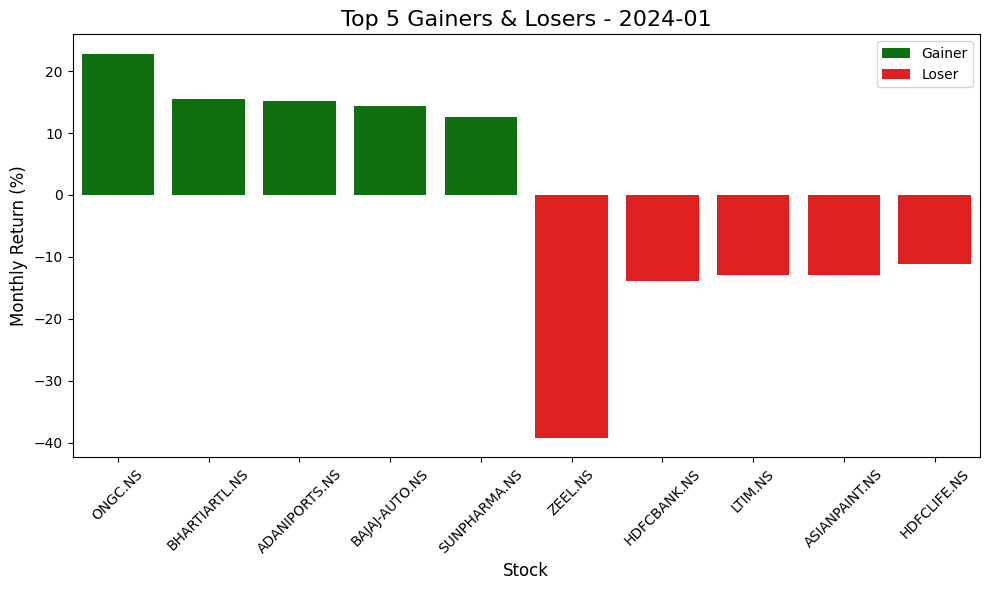

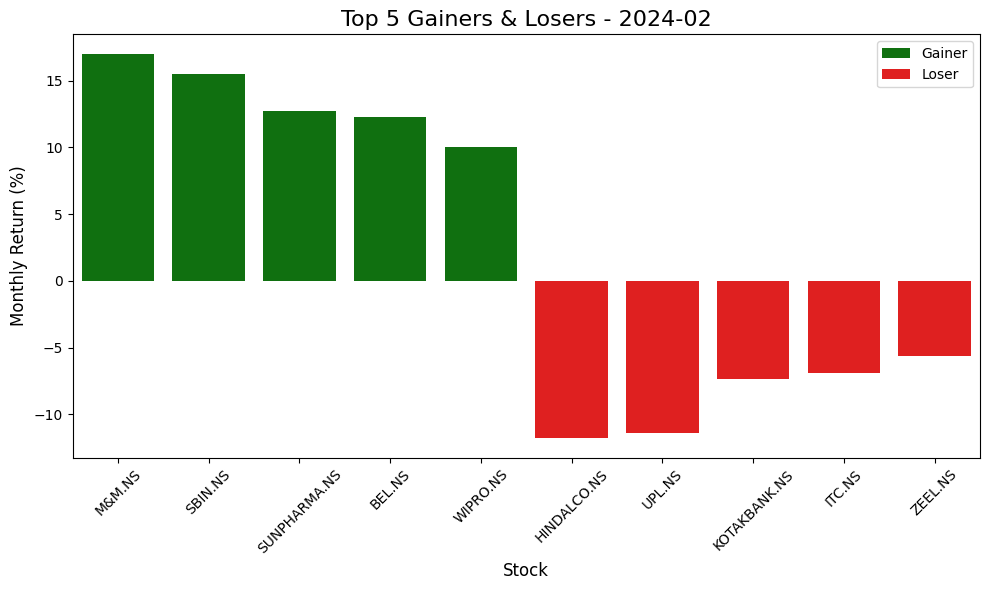

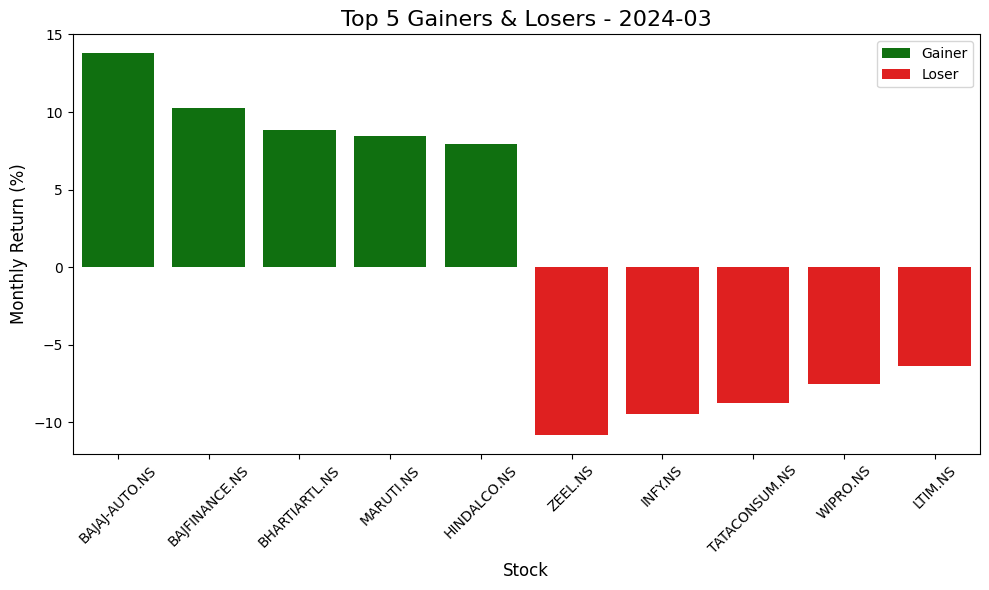

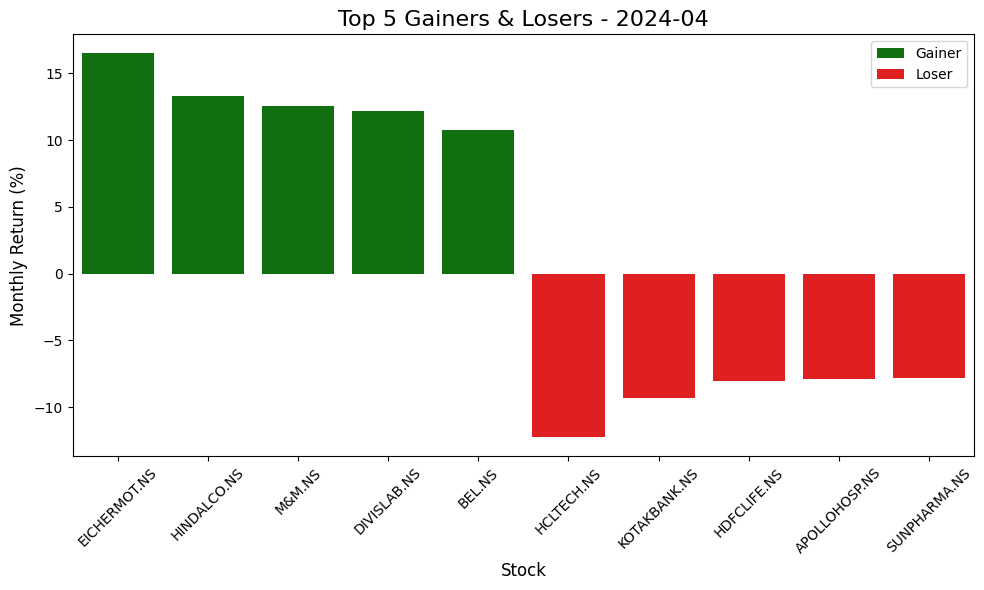

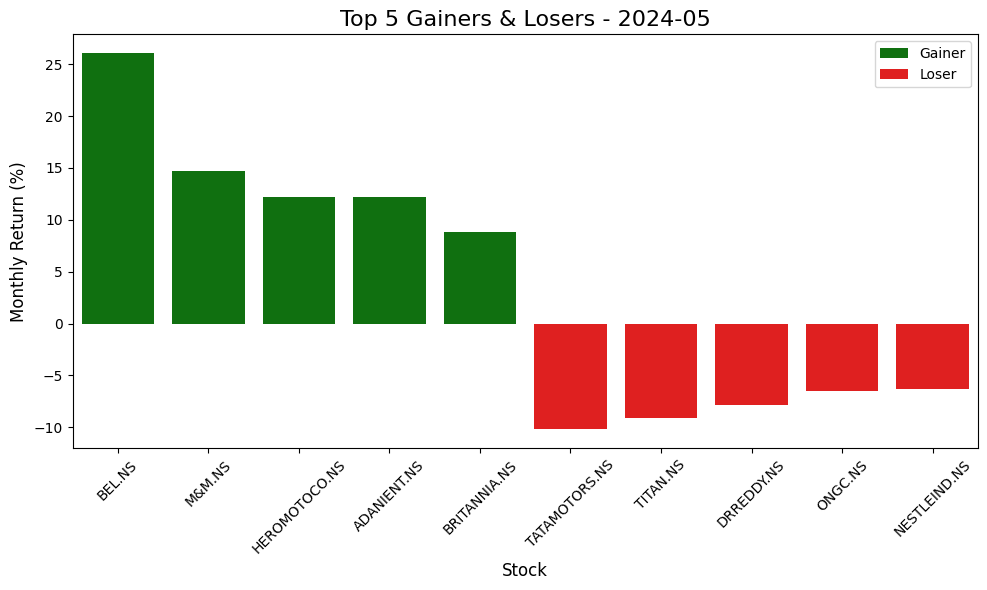

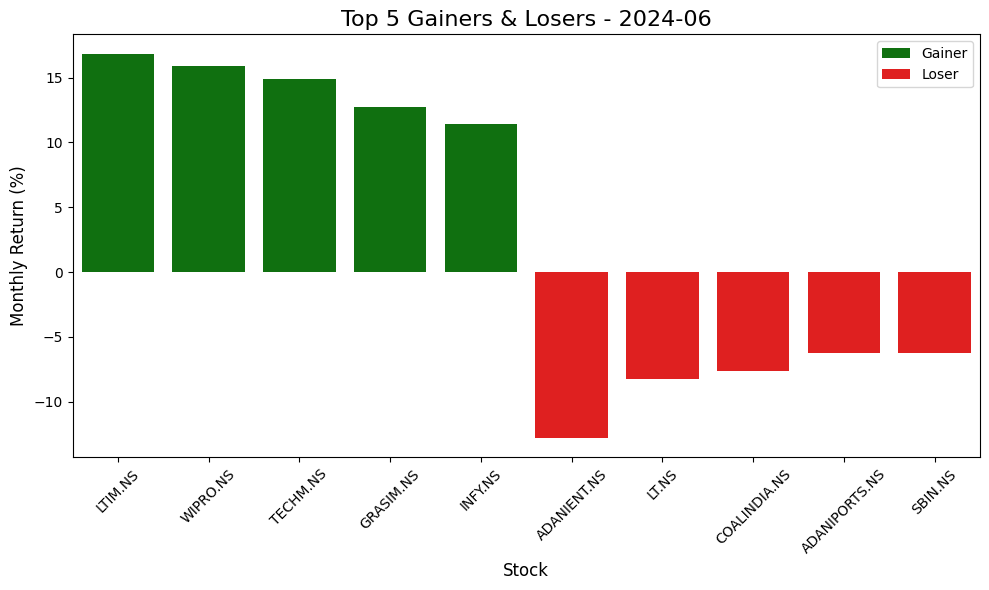

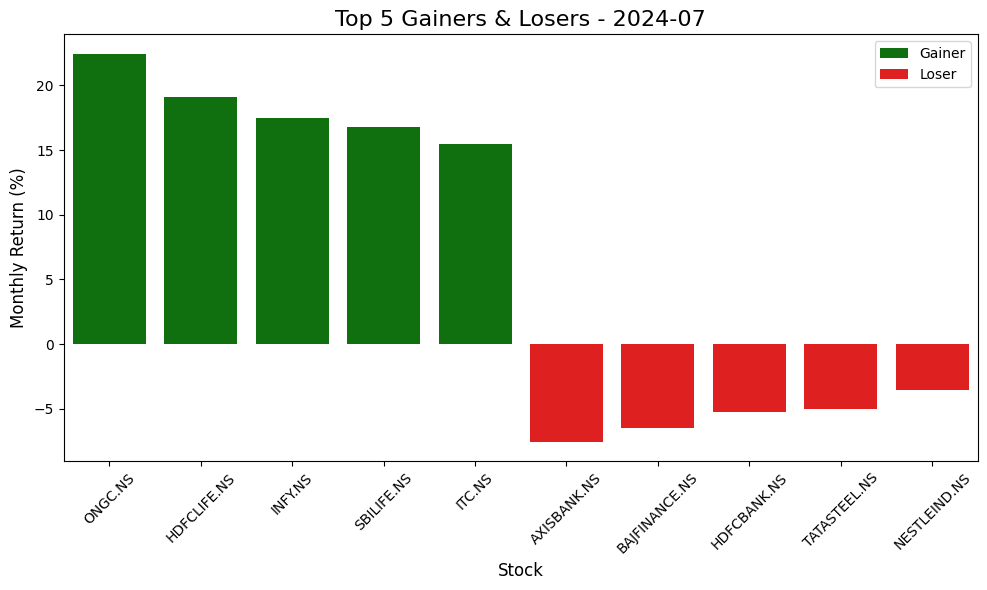

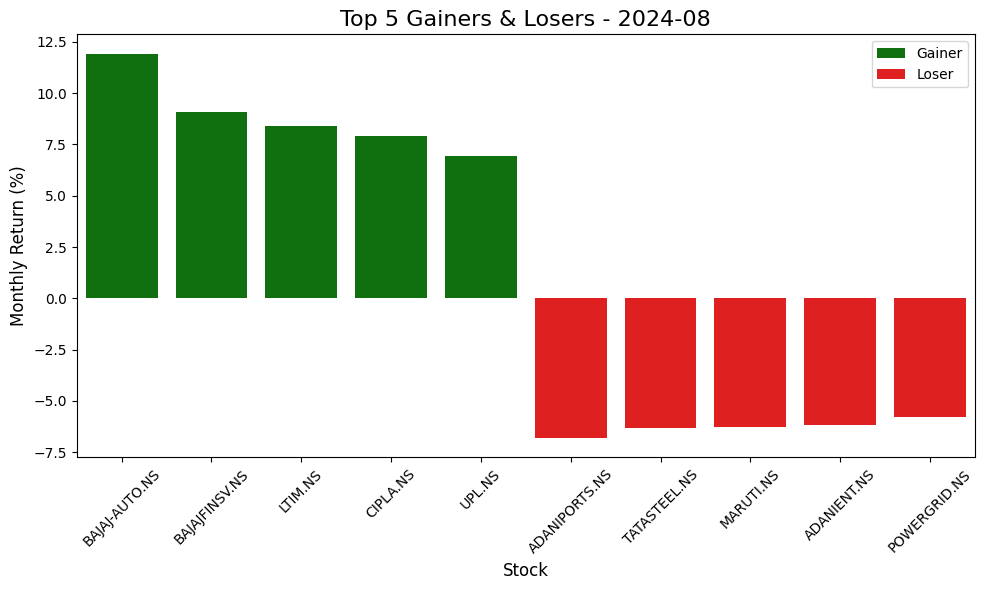

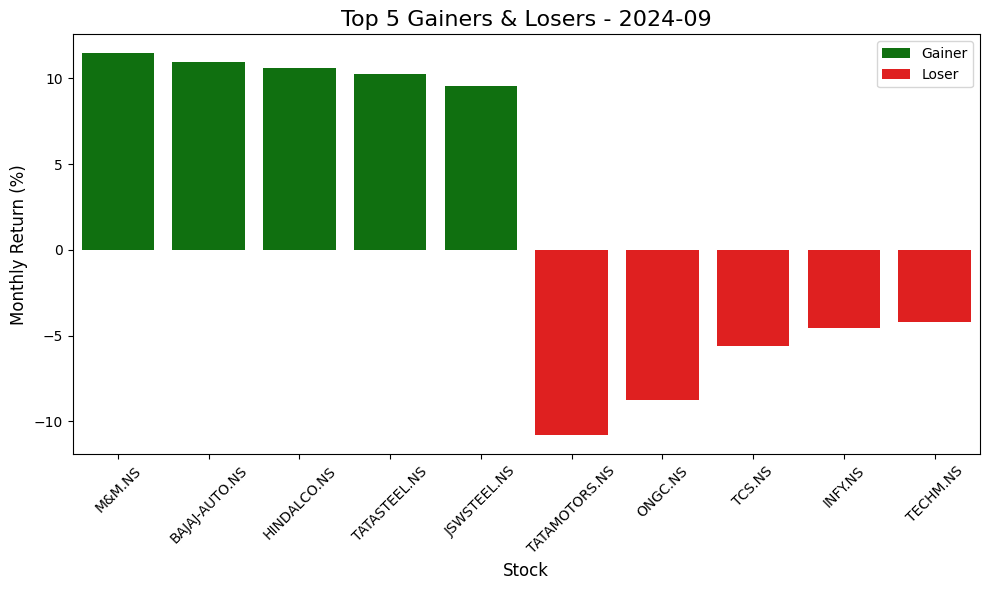

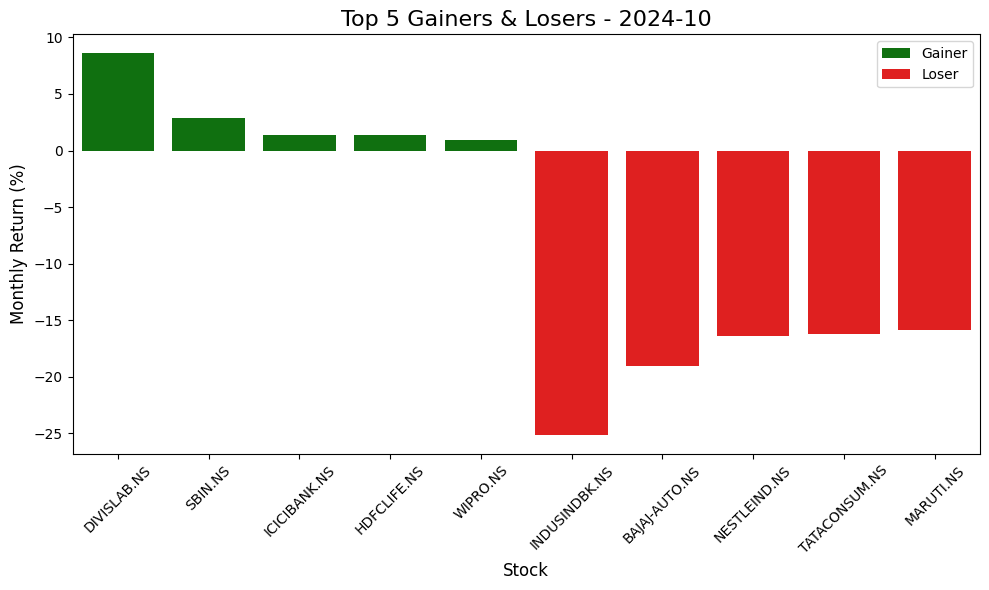

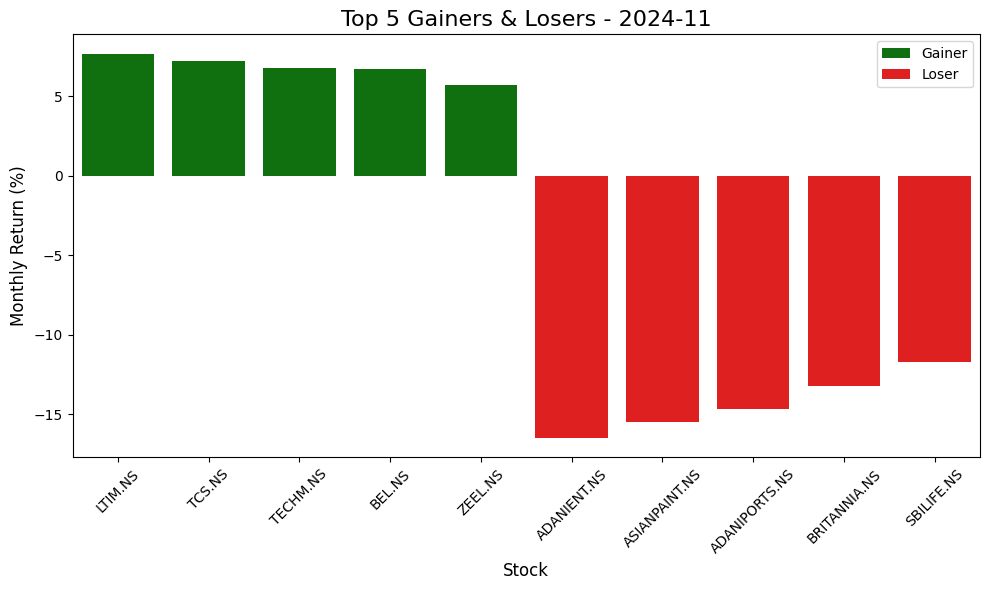

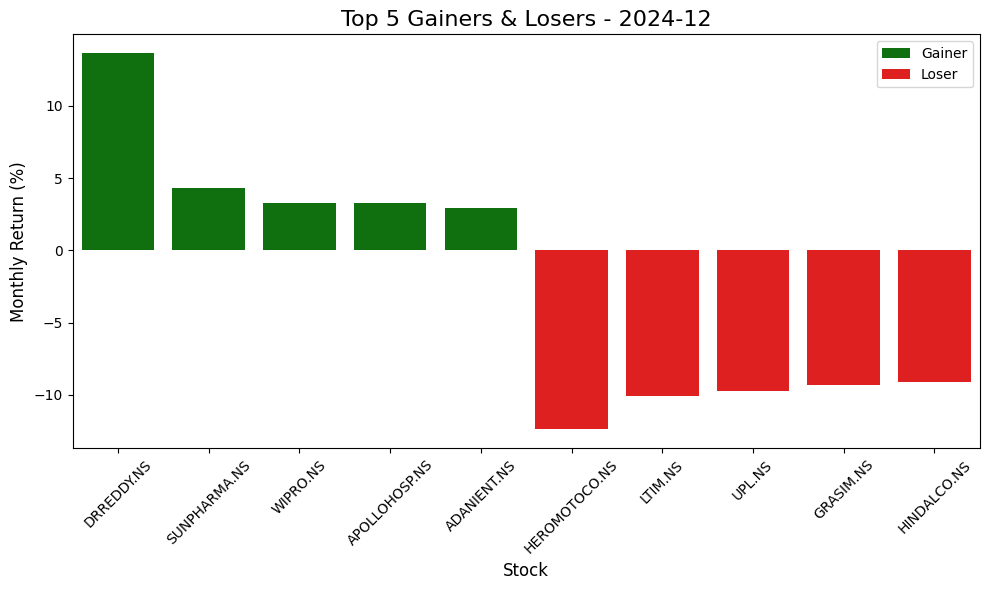

✅ File saved successfully to 'nifty50_cleaned.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Ensure Date column is datetime
# -----------------------------
df_clean["Date"] = pd.to_datetime(df_clean["Date"])

# -----------------------------
# 2. Add Month-Year column
# -----------------------------
df_clean["Month"] = df_clean["Date"].dt.to_period("M")

# -----------------------------
# 3. Compute monthly return per stock
# -----------------------------
monthly_return = (
    df_clean.groupby(["Stock", "Month"])
    .agg(
        First_Close=("Close", "first"),
        Last_Close=("Close", "last")
    )
    .reset_index()
)
monthly_return["Monthly_Return"] = (
    (monthly_return["Last_Close"] - monthly_return["First_Close"]) / monthly_return["First_Close"]
) * 100

# -----------------------------
# 4. Identify top 5 gainers and losers per month
# -----------------------------
top_gainers = monthly_return.groupby("Month").apply(lambda x: x.nlargest(5, "Monthly_Return")).reset_index(drop=True)
top_losers  = monthly_return.groupby("Month").apply(lambda x: x.nsmallest(5, "Monthly_Return")).reset_index(drop=True)

# -----------------------------
# 5. Plot dashboard-style charts per month
# -----------------------------
months = monthly_return["Month"].unique()

for month in months:
    # Use .copy() to avoid SettingWithCopyWarning
    gainers = top_gainers[top_gainers["Month"] == month].copy()
    losers  = top_losers[top_losers["Month"] == month].copy()
    
    # Assign type for coloring
    gainers['Type'] = 'Gainer'
    losers['Type']  = 'Loser'
    
    # Combine data for plotting
    data = pd.concat([gainers, losers])
    
    # Create figure
    plt.figure(figsize=(10,6))
    sns.barplot(
        x="Stock",
        y="Monthly_Return",
        hue="Type",
        data=data,
        palette={"Gainer": "green", "Loser": "red"}
    )
    
    plt.title(f"Top 5 Gainers & Losers - {month}", fontsize=16)
    plt.ylabel("Monthly Return (%)", fontsize=12)
    plt.xlabel("Stock", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="")
    plt.tight_layout()
    plt.show()
# Save the file
df_clean.to_csv("nifty50_cleaned.csv", index=False)
print("✅ File saved successfully to 'nifty50_cleaned.csv'")